<a href="https://colab.research.google.com/github/RaniaBouchrara/Stage-Rania/blob/master/Lorenz_stochastique1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sdeint    
#sdeint permet la résolution de l'équation différentielle stochastique

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for sdeint: filename=sdeint-0.2.1-cp36-none-any.whl size=27747 sha256=5cd8fe849dc1606bd9bdf648e7f854ca99e1788df224a6c371d00a543f81d0e9
  Stored in directory: /root/.cache/pip/wheels/6d/76/bf/cd470aaeb760f7ac85bca1614606ed5760408dbf5149240ba4
Successfully built sdeint


In [2]:
#importer l'ensemle des bibliothèques nécessaires
import sdeint
import sys  
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

In [31]:
'la génération des données et initialisation des paramètres du modèle ainsi que les variables d''intégration, d''apprentissage et de test'
class GD:
    model = 'Lorenz_63'
    class parameters: 
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
        theta = 1000.0
    
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation

    '''var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_obs = 2.0 # variance of the observation error to generate observation'''

In [32]:
#définition des équations différentielles stochastiques
def Stoch_Lorenz_63(S,t,sigma=GD.parameters.sigma, rho = GD.parameters.rho, beta = GD.parameters.beta, theta = GD.parameters.theta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0])-4*S[0]/(2*theta);
    x_2 = S[0]*(rho-S[2])-S[1] -4*S[1]/(2*theta);
    x_3 = S[0]*S[1] - beta*S[2] -8*S[2]/(2*theta);
    dS  = np.array([x_1,x_2,x_3]);
    return dS
    
#définition du mouvement brwonien 
def brownian_process(S,t,sigma=GD.parameters.sigma, rho = GD.parameters.rho, beta = GD.parameters.beta, theta = GD.parameters.theta):
    x_1 = 0.0;
    x_2 = (rho - S[2])/np.sqrt(theta);
    x_3 = (S[1])/np.sqrt(theta);
    dS  = np.array([x_1,x_2,x_3]);
    G = np.zeros((3,3))
    G[0,0] = x_1
    G[1,0] = x_2
    G[2,0] = x_3
    #np.fill_diagonal(G,dS)
    return G

In [33]:
#génération d'une solution des équations différentielles à partir d'un x0 donné
np.random.seed(1)
x0 = np.array([8.0,0.0,30.0]);
tspan = np.arange(0,70+0.000001,10E-5) 
S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)

Text(0.5, 0.92, 'Stochastic Lorenz flow')

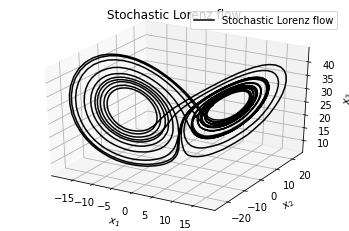

In [34]:
#traçage du flux du modèle stochastique de lorenz
#Undersampling to dt = .01
S_u  = S[::100]
fig=plt.figure()
ax=fig.gca(projection='3d')
line1,=ax.plot(S_u[:2000,0],S_u[:2000,1],S_u[:2000,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Stochastic Lorenz flow'])
plt.title('Stochastic Lorenz flow')

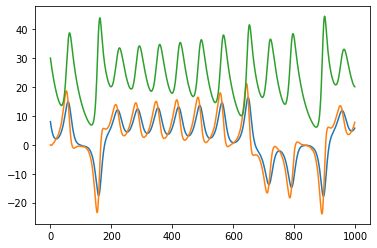

In [35]:
#simulation de la série temporelle
plt.plot(S_u[:1000,:])

In [36]:
def generate_data(GD):
    """ Generate the true state, noisy observations and catalog of numerical simulations. """

    # initialization
    class xt: #xt : test (série temporelle)
        values = [];
        time = [];
    class yo: #yo : observation (assimilation des données)
        values = [];
        time = [];
    class catalog: #catalog : train (base d'apprentissage)
        analogs = [];
        successors = [];
        source = [];
        time = [];
    
    # test on parameters
    if GD.dt_states>GD.dt_obs:
        print('Error: GD.dt_obs must be bigger than GD.dt_states');
    if (np.mod(GD.dt_obs,GD.dt_states)!=0):
        print('Error: GD.dt_obs must be a multiple of GD.dt_states');

    # use this to generate the same data for different simulations
    np.random.seed(1);

    # 5 time steps (to be in the attractor space)  
    x0 = np.array([8.0,0.0,30.0]);
    #S = odeint(Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)
    x0 = S[S.shape[0]-1,:];

    # generate true state (xt)
    #S = odeint(Lorenz_63,x0,np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)
    T_test = S.shape[0];      
    t_xt = np.arange(0,T_test,GD.dt_states);       
    xt.time = t_xt*GD.dt_integration;
    xt.values = S[t_xt,:];
        
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),GD.sigma2_obs*np.eye(3,3),T_test);
    yo_tmp = S[t_xt,:]+eps[t_xt,:];
    t_yo = np.arange(0,T_test,GD.dt_obs);
    i_t_obs = np.where((np.in1d(t_xt,t_yo))==True)[0];
    yo.values = xt.values*np.nan;
    yo.values[np.ix_(i_t_obs,GD.var_obs)] = yo_tmp[np.ix_(i_t_obs,GD.var_obs)];
    yo.time = xt.time;
       

    #generate catalog
    #S =  odeint(Lorenz_63,S[S.shape[0]-1,:],np.arange(0.01,GD.nb_loop_train+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)
    T_train = S.shape[0];
    eta = np.random.multivariate_normal(np.zeros(3),GD.sigma2_catalog*np.eye(3,3),T_train);
    catalog_tmp = S+eta;
    catalog.analogs = catalog_tmp[0:-GD.dt_states,:];
    catalog.successors = catalog_tmp[GD.dt_states:,:]
    catalog.source = GD.parameters;
  # reinitialize random generator number    
    np.random.seed()

    return catalog, xt, yo;

In [37]:
#run the data generation
catalog, xt, yo = generate_data(GD)

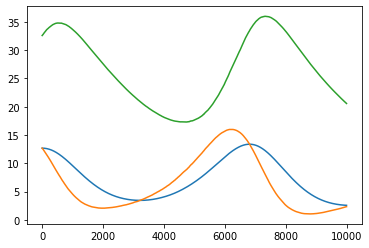

In [38]:
plt.plot(catalog.analogs[:10000,:])

In [39]:
#training data
batch_size = 50
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration #gradient de X_train
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1])) #successors de catalog

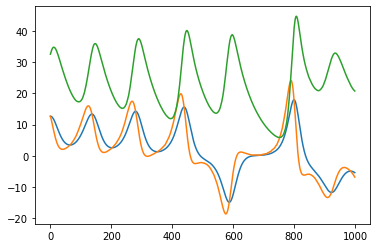

In [40]:
plt.plot(X_train[:1000,0,:])
plt.show()

In [41]:
#initialisation des paramètres du réseau de neurones pour l'apprentissage deep learning
params = {}
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_output']=3
params['dim_observations'] = 3
params['dim_hidden']=3
params['ntrain']=[1000,200]
params['dt_integration'] = GD.dt_integration
pretrained = False
path = ''# to be defined 
file_name = '' # to be defined

In [42]:
#classe du modèle dynamique qui permet de calculer le gradient 
np.random.seed(0)
torch.manual_seed(0)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_input'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_input'],params['dim_input']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_input'], params['dim_input']) 
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            aug_inp = inp
            BP_outp = (torch.zeros((aug_inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(aug_inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](aug_inp)[:,0]*self.BlinearCell2[i](aug_inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)

In [43]:
#classe du modèle dynamique qui permet de calculer l'intégrale
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp,dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k1 = self.Dyn_net(inp,dt)
            inp_k2      = inp + 0.5*params['dt_integration']*k1
            k2     = self.Dyn_net(inp_k2,dt)
            inp_k3      = inp + 0.5*params['dt_integration']*k2       
            k3     = self.Dyn_net(inp_k3,dt)
            inp_k4      = inp + params['dt_integration']*k3          
            k4     = self.Dyn_net(inp_k4,dt)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1
#int_net est appelée lorsqu'on lance le modèle RINN (dans train_model) elle nécessite deux variables dont une la variable dt qui 
#est une variable d'intégration et la variable inputs (train_model=model(inputs,dt)) et retourne une prédiction 

In [44]:
#construction de x,y et z
#conversion de x,y et z d'un numpy de type tableau à un objet torch de type float (réel)
dt       = params['dt_integration']
aug_vect = []  
x = torch.from_numpy(X_train).float() 
y = torch.from_numpy(Y_train).float()
z = torch.from_numpy(Grad_t).float()

#construction du modèle RINN
#critère à minimiser (mse) 
#optimizer(adam)
modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(),lr = 0.001)

if pretrained : 
    modelRINN.load_state_dict(torch.load(path + file_name))

# L63 Patch data extraction

In [45]:
from sklearn.feature_extraction import image

time_step = 1  

#extract subsequences 
#creation de bout de séries temporelles
dT = 2
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:7000:time_step,:],(dT,3),5000)
dataTestNoNaN     = image.extract_patches_2d(xt.values[7000::time_step,:],(dT,3),1000)

In [46]:
x_train         = np.moveaxis( dataTrainingNoNaN.reshape((dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2])) , 2 , 1 )
x_test         = np.moveaxis( dataTestNoNaN.reshape((dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2])) , 2 , 1 )


# Learning model

In [47]:
import os
import tensorflow.keras as keras
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

In [48]:
# Create training/test data pytorch tensors and associated   
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train)) # create your dataset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test)) # create your dataset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
}
#datatloaders(entrée et sortie sont des données du RN)
#x(t) est rapprochée x(t)-x(t-dt)/dt
#x(t0) est rapprochée par x(t+dt),x(t+2dt),...
#batch_size=32 (état au temps t) inputs
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

In [49]:
#create an optimizer object
#Adam optimizer with learning rate 1e-3
optimizer        = optim.Adam(modelRINN.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

#mean-squared error loss
criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

#training function
def train_model(model, dt, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_var  = 0.0

            # Iterate over data.
            for inputs_ in dataloaders[phase]:
                inputs = inputs_[0]
                #inputs = inputs.to(device)
                #print(inputs.size(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    x_init   = inputs[:,:,0].view(-1,3) # initial state
                    x_target = inputs[:,:,1].view(-1,3) # target state
                    #print(x_init.size(),flush=True)
                    outputs = model(x_init,dt)
                    #print(outputs[0].size(),flush=True)
                    #loss = criterion(outputs, inputs)
                    loss = torch.mean((outputs[0] - x_target)**2)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss   += loss.item() * inputs.size(0)
                #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
            if phase == 'train':
                scheduler.step()

            epoch_loss  = running_loss / dataset_sizes[phase]
            if phase == 'train':
              epoch_nloss = epoch_loss / var_Tr
            else:
              epoch_nloss = epoch_loss / var_Tt
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4e} NLoss: {:.4e} '.format(
                phase, epoch_loss, epoch_nloss))
#            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format( 
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model 

In [50]:
#training   
dt         = torch.nn.Parameter(torch.Tensor([0.01]))
num_epochs = 10
modelRINN  = train_model(modelRINN, dt, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/9
----------
train Loss: 6.1006e-03 NLoss: 6.5598e-05 
val Loss: 6.8952e-04 NLoss: 3.6022e-06 

Epoch 1/9
----------
train Loss: 1.5960e-04 NLoss: 1.7161e-06 
val Loss: 2.2309e-04 NLoss: 1.1655e-06 

Epoch 2/9
----------
train Loss: 5.6718e-05 NLoss: 6.0987e-07 
val Loss: 2.2882e-04 NLoss: 1.1954e-06 

Epoch 3/9
----------
train Loss: 3.3921e-05 NLoss: 3.6474e-07 
val Loss: 3.0129e-04 NLoss: 1.5740e-06 

Epoch 4/9
----------
train Loss: 2.8412e-05 NLoss: 3.0551e-07 
val Loss: 3.4848e-04 NLoss: 1.8205e-06 

Epoch 5/9
----------
train Loss: 2.5975e-05 NLoss: 2.7930e-07 
val Loss: 3.7087e-04 NLoss: 1.9375e-06 

Epoch 6/9
----------
train Loss: 2.4196e-05 NLoss: 2.6017e-07 
val Loss: 3.8519e-04 NLoss: 2.0123e-06 

Epoch 7/9
----------
train Loss: 2.2795e-05 NLoss: 2.4511e-07 
val Loss: 3.9101e-04 NLoss: 2.0427e-06 

Epoch 8/9
----------
train Loss: 2.1731e-05 NLoss: 2.3367e-07 
val Loss: 3.9015e-04 NLoss: 2.0382e-06 

Epoch 9/9
----------
train Loss: 2.0928e-05 NLoss: 2.2503e-07 
v

In [51]:
reel = training_dataset[:,:,0][0].view(-1,3) #***

In [52]:
pred, K1 = modelRINN(reel,dt)

In [53]:
reel[:100,0]

tensor([ 3.7329,  3.8798,  6.4938,  3.5189,  6.3860,  6.1422, 10.2102,  9.4500,
         4.8180, 10.4302, 10.6631, 13.3393, 13.3401,  3.5908, 12.8010, 11.0059,
         3.8905,  4.8246,  4.6001,  3.5984,  6.2965, 11.6725,  3.6009, 11.9518,
        13.3491, 11.1768,  4.7498,  6.8990,  6.1160,  5.0789,  5.6510,  4.0437,
        13.2720, 12.6419,  5.1950, 10.7865, 10.5960, 11.2001,  3.5142, 12.0446,
         3.5352,  3.7199,  5.7542, 11.6473, 13.2816, 10.9671,  4.4364, 12.5959,
         3.7421, 13.2361,  3.6280,  3.5792,  8.5759, 11.7707, 10.5728,  4.7159,
         4.7159,  5.3612, 11.1091,  3.6943,  3.6475, 10.7820,  4.8090, 12.8600,
         5.0781,  6.5442,  3.5187,  8.9719, 13.2816,  6.5735,  4.7735,  8.4269,
         4.2344,  4.1372,  4.9076, 12.7333,  4.0415,  3.5133, 13.3476, 12.0239,
         4.4397, 11.0864,  4.1287,  3.8138,  6.7667,  3.5662,  3.7881,  4.4267,
         4.5305,  4.9253,  6.1786,  9.2593,  5.7542, 11.6008,  7.6121,  6.8839,
         8.5910, 11.5489,  4.0089,  8.77

In [54]:
pred[:100,0].detach()    

tensor([ 3.7270,  3.8735,  6.4838,  3.5142,  6.3855,  6.1411, 10.2199,  9.4398,
         4.8150, 10.4407, 10.6743, 13.3512, 13.3520,  3.5864, 12.8164, 10.9991,
         3.8842,  4.8166,  4.5924,  3.5930,  6.2866, 11.6685,  3.5954, 11.9666,
        13.3569, 11.1896,  4.7419,  6.8996,  6.1149,  5.0705,  5.6419,  4.0371,
        13.2777, 12.6477,  5.1865, 10.7790, 10.5879, 11.1940,  3.5094, 12.0430,
         3.5306,  3.7140,  5.7525, 11.6432, 13.2946, 10.9601,  4.4290, 12.6005,
         3.7362, 13.2495,  3.6237,  3.5739,  8.5652, 11.7851, 10.5647,  4.7081,
         4.7081,  5.3524, 11.1216,  3.6901,  3.6433, 10.7745,  4.8061, 12.8752,
         5.0754,  6.5340,  3.5137,  8.9778, 13.2946,  6.5733,  4.7704,  8.4312,
         4.2308,  4.1335,  4.8994, 12.7487,  4.0377,  3.5085, 13.3554, 12.0222,
         4.4364, 11.0989,  4.1219,  3.8078,  6.7564,  3.5609,  3.7821,  4.4233,
         4.5229,  4.9224,  6.1777,  9.2490,  5.7525, 11.6148,  7.6143,  6.8844,
         8.5802, 11.5628,  4.0051,  8.76

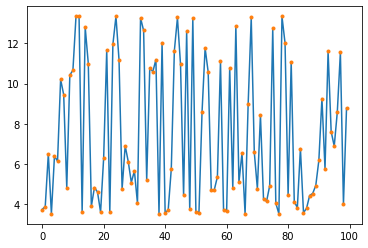

In [55]:
plt.plot(reel[:100,0],)
plt.plot(pred[:100,0].detach(),'.')
plt.show()

In [ ]:
print ('Optimizing flowmap')        
for t in range(params['ntrain'][1]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(pred, y[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss) 

In [ ]:
pred = [torch.from_numpy(xt.values[:1,:]).float()]
for i in range(1000):  
    pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

plt.plot(torch.stack(pred).data.numpy()[:1000,0,0],label = "Prediction from LQM Dynamical model")
plt.plot(xt.values[:1000,0],label = "True state")  

### Test/Evaluation du modèle

Calcul de MSE

In [ ]:
from sklearn.metrics import mean_squared_error 

print('mse (sklearn): ', torch.nn.MSELoss(xt,pred))

mse (sklearn):  MSELoss()


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Calcul de MSE normalisée

In [56]:
from sklearn.metrics import r2_score 
NMSE = 1- r2_score(reel,pred.detach())

In [57]:
NMSE

4.584720175837553e-06